## Test Markdown for Task 1

We present a novel dataset based on Sentinel-2 satellite images covering <span style="color:blue; font-weight:bold;">13 spectral bands</span> and consisting out of <span style="color:blue; font-weight:bold;">10 classes with 2 to 3k per class</span> in total <span style="color:blue; font-weight:bold;">27,000 labeled and geo-referenced images</span>. We provide benchmarks for this novel dataset with its spectral bands using state-of-the-art deep Convolutional Neural Network (CNNs). With the proposed novel dataset, we achieved an overall classification accuracy of <span style="color:red; font-weight:bold;">98.57%</span>. The resulting classification system opens a gate towards a number of Earth observation applications. We demonstrate how this classification system can be used for detecting land use and land cover changes and how it can assist in improving geographical maps. The geo-referenced dataset EuroSAT is made publicly available here.

Things to understand:
- Spectral bands - different ranges of wavelengths of light that are captured by a satellite sensor
- 10 classes
- Labeled and geo-referenced images
- CNNs
- Why is land use and cover classification relevant?
- supervised machine learning
-  mutli-spectral image data provided by the Sentinel-2A satellite 

## Spectral Bands and Classes
<img title="a title" alt="Alt text" src="Images/spectral_bands.png" width="250" height="200"> <img title="a title" alt="Alt text" src="Images/sample_image_patches.png" width="350" height="200">

The three bands B01, B09 and B10 are intended to be used for the correction of atmospheric effects(e.g., aerosols, cirrus or water vapor). The remaining bands are primarily intended to identify and monitor land use and land cover classes.

## Classification Accuracy

<img title="a title" alt="Alt text" src="Images/classification_accuracy_train_test.png" width="600" height="250"> <img title="a title" alt="Alt text" src="Images/classification_accuracy_best.png" width="350" height="200"> <img title="a title" alt="Alt text" src="Images/classification_accuracy_resnet.png" width="200" height="200">

Notes
- The aim of land use and land cover classification is to automatically provide labels describing the represented physical land type or how a land area is used
- Data only covers EU countries
- In order to improve the chance of getting valuable image patches, we selected satellite images with a low cloud level. Besides the possibility to generate a cloud mask, ESA provides a cloud level value for each satellite image allowing to quickly select images with a low percentage of clouds covering the land scene

## Tips for High Marks
- Explore different models in sklearn beyond those covered in class
  - Describe conclusions
  - Use different metrics and see what you observe (Dont just add all, understand why and show it)
- Visualisation examples
    - Understand how well your model and feature selection works
    - Start with a qn -> hypotheses -> Then BAM
- Use functions as much as possible, minimal classes
- Print images, accuracies, etc as much as possible (So grader can glance)
- NO PANDAS
- Run and save notebook using Pickl (?) so on appear, they can see everything
- Technical mastery of module curriculum This include illustration/utilization of items like CV, proper training/testing protocols and
visualizations where appropriate.

## Dont's for Low Marks
- Perform pre-processing steps we haven't covered like noise/outlier removal
  - Wont get you additional marks
- Hyperparameter optimisation -> Explain I am trying to optimise this parameter, this is what it does, and these are the values ive tried
  - You can do this manually by looking at a range of values
  - Describe the quantities you are optimising
  - There are systematic methods like GridSearchCV, DONT USE! 

In [35]:
import numpy as np
from sklearn.svm import SVC
import matplotlib.pyplot as plt 
from sklearn.model_selection import cross_val_score, KFold
from  sklearn.preprocessing import OneHotEncoder
from functions.pre_processing import find_missing_values, find_negative_values, plot_split_of_values
from sklearn.feature_selection import r_regression, SelectKBest
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [36]:
x_train = np.load("datasets/x_train.npy")
x_test = np.load("datasets/x_test.npy")
y_train = np.load("datasets/y_train.npy")
y_test = np.load("datasets/y_test.npy")

# ((16200 rows, 512 cols) for x_train, (5400 rows, 512 cols) for x_test) | (16200,) -> Represents one dimensional array for y_train, (5400,) -> Represents one dimensional array for for y_test
# Train test split -> 75/25
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

# All values float

print(x_train) # 512 features -> Numerical features - Features with values that are continuous on a scale, statistical, or integer-related
print(np.unique(y_train)) # [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.] -> 10 classes of possible outputs, and the reoccurences are just one of these values indicating a class

(16200, 512)
(5400, 512)
(16200,)
(5400,)
[[0.46573916 0.         0.         ... 0.15444896 0.02761412 0.        ]
 [0.         0.         0.         ... 0.42438483 0.08174433 0.0502976 ]
 [0.15436319 0.01907348 0.02712335 ... 0.         0.08633541 0.        ]
 ...
 [0.         0.22086209 0.07728773 ... 0.11481228 0.1169597  0.        ]
 [0.         0.         0.15300888 ... 0.         0.04044536 0.00111793]
 [0.0839657  0.         0.         ... 0.00469289 0.13740638 0.        ]]
[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


## Task 1

Write a Python program to pre-process and transform the dataset into a format suitable for developing machine learning models. Use pearson correlation method to identify ten most important features. Use these features to build a SVM classifier and evaluate your model’s performance.

Markdown Question: The difficulty in using pearson correlation method for feature selection is determining the appropriate number of features to select. The method described in the module to automatically choose the appropriate number of features will be computationally very expensive when the number of features is high. Describe an alternative method to reduce the computational complexity of the method discussed in class for datasets with large number of features. Describe the method. No need to write the program.

<span style="font-weight:bold;">Save your response (program and markdown) as task1.ipynb.</span>

Missing Values in x_train -> 0, Missing Values in x_test -> 0
Negative Values in x_train -> 0, Negative Values in x_test -> 0


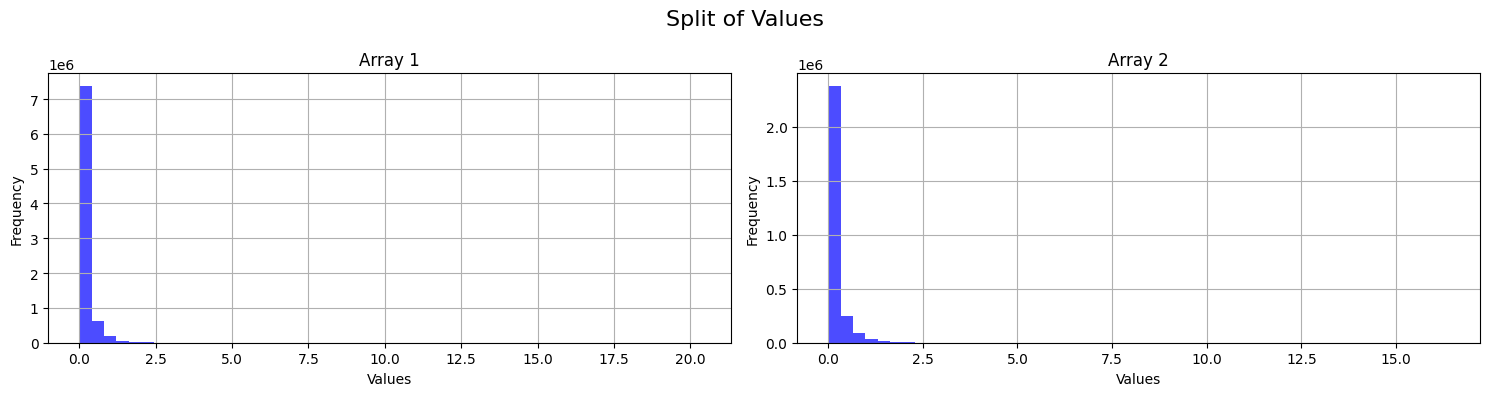

In [37]:
# ------- PRE PROCESSING [Fix Messed up Data] ---------
# PRE PROCESSING done on both training and test data
# Imputation -> (Univariate and Multivariate) -> process of inferring missing values based on the available data.

# Don't need OneHotEncoder or any other because all are float values
'''
Try different techniques of pre processing and transformation and see the difference in results?
'''

print(f"{find_missing_values(x_train, "x_train")}, {find_missing_values(x_test, "x_test")}")
print(f"{find_negative_values(x_train, "x_train")}, {find_negative_values(x_test, "x_test")}")
# Dont have any missing or negative values
plot_split_of_values([x_train, x_test])

# Variance Threshold?


## Because of no missing values, Imputation was not used

Pearson Classification Evaluation Table

<img title="a title" alt="Alt text" src="Images/pearson_evaluation.png" width="350" height="200">

[178 479 136 369 254 440  38 485 116  64]


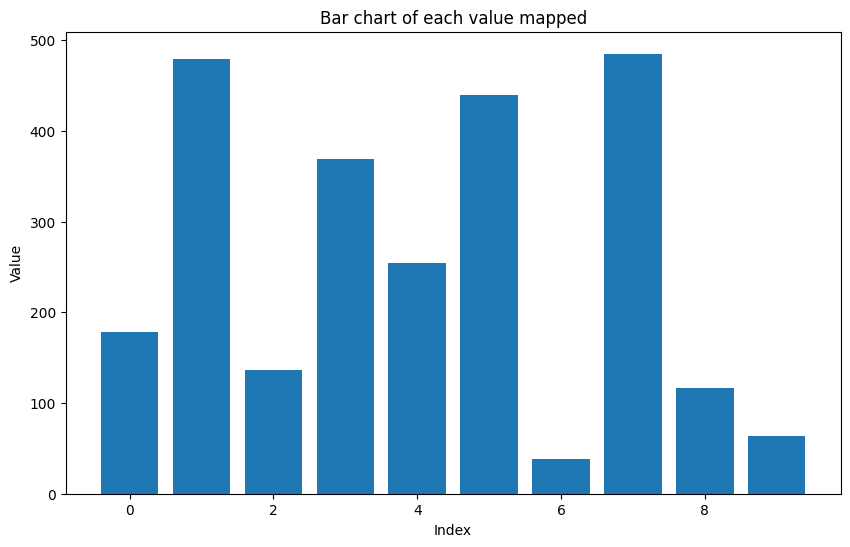

In [55]:
# ------- TRANSFORMATION [Standardise it] ---------
# Normalisation -> Feature selection
# Whats Standard Scaler 
# ------- FEATURE SELECTION -> PEARSON CLASSIFICATION [Helps estimate the importance of a feature] ---------
    # Somehow visualise this

# Feature selection (if x features are highly correlated, remove some because dont need all)

# Scaler

## WHY NORMALISATION BEFORE PR Coeffeciant & Feature Selection -> Normalization ensures that all features are on a similar scale, which can help prevent certain features from dominating the correlation calculations or feature selection process due to differences in their scales.
 # Is -1, 1 right?

# Why? Because the classes numbers dont mean anything and are separate
# ohc = OneHotEncoder(categories='auto', dtype=float)
# x_ohc = ohc.fit_transform(x_train)
# x_test_ohc = ohc.fit_transform(x_test)
# --------------- EVALUATE DIFFERENT NORMALISATION METHODS [BEST PERFORMANCE IS MinMaxScaler]

min_max_scaler = MinMaxScaler(feature_range=(-1, 1)) # ------ Doing normalisation before/after pearson has no impact
x_train_norm = min_max_scaler.fit_transform(x_train)
x_test_norm = min_max_scaler.fit_transform(x_test)

# standard_scaler = StandardScaler()
# x_train_norm = standard_scaler.fit_transform(x_train)
# x_test_norm = standard_scaler.fit_transform(x_test)

# robust_scaler = RobustScaler()
# x_train_norm = robust_scaler.fit_transform(x_train)
# x_test_norm = robust_scaler.fit_transform(x_test)

# -------------------------------------------------------

# Any difference bwn SelectKBest and Pearson?
# skb = SelectKBest(r_regression, k=10)
# skb.fit(x_train, y_train)
# x_train_fit = skb.transform(x_train)
# x_test_fit = skb.transform(x_test)


# ----- Standard Scaler and MIN MAX SCALER DIFFERENCE

# Take a look at the correlation values
pr_coeff = r_regression(x_train_norm, y_train)
# print(pr_coeff)
imp_features = np.argsort(np.abs(pr_coeff))

print(imp_features[:10])

data = imp_features[:10]
plt.figure(figsize=(10, 6))
plt.bar(range(len(data)), data)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Bar chart of each value mapped')
plt.show()


# correlation_matrix = np.corrcoef(x_train_norm, rowvar=False)

# Min - -0.318938080678068
# Max - 0.3630486169457985

# ----------------------------------------------------------------

# One-Hot Encoding -> The categorical feature is not ordinal 
# Label and Ordinal Encoding -> The categorical feature is ordinal (Like JR, SR, high school)


In [51]:
# What does the C hyperparameterisation do?
# What parameters can be optimised in SVC

# ----- Show how this figure was gotten in terms of parameters to get the best output
# Holdout method
# C = 50, kernel - rbf
svc = SVC(kernel='rbf') # Why poly and how does it work
selected_features = x_train_norm[:, imp_features[:10]]
selected_test_features = x_test_norm[:, imp_features[:10]]

svc.fit(selected_features, y_train)
svc.score(selected_test_features, y_test) 

# Works well after normalisation, its the feature selection thats messing it up (Could be 10 is not the right number or bad features selected)
# 
print('Training Accuracy: ', svc.score(selected_features, y_train))
print('Testing Accuracy: ', svc.score(selected_test_features, y_test))

# CROSS VALIDATION AND K-FOLD VALIDATION NEEDED 

# ------------------------------------------------------------------------------------

# normal dataset
    # All features
        # Training Accuracy:  0.9711111111111111
        # Testing Accuracy:  0.9283333333333333
    # Top 10 features
        # Training Accuracy:  0.5820987654320988
        # Testing Accuracy:  0.5507407407407408

# normalised dataset [better with normalisation]
    # All features (rbf)
        # Training Accuracy:  0.9761728395061728
        # Testing Accuracy:  0.9305555555555556
    # Top 10 features ------ BEST SO FAR -------
        #  ----- RBF (no C)
        # Training Accuracy:  0.5920987654320987
        # Testing Accuracy:  0.5607407407407408


        # NOT USING RBF DUE TO OVERFITTING (Large difference between training and test)
        # kernel -> rbf | C -> 7 + StandardScaler  ---- BEST ----
        # Training Accuracy:  0.6462345679012346
        # Testing Accuracy:  0.5648148148148148

        # kernel -> rbf | C -> 50 + StandardScaler -> Overfitting
        # Training Accuracy:  0.7183950617283951
        # Testing Accuracy:  0.5592592592592592   

        # --------------------------------
        # Linear -> C= 15
        # Training Accuracy:  0.49679012345679013
        # Testing Accuracy:  0.49092592592592593


Training Accuracy:  0.5920987654320987
Testing Accuracy:  0.5607407407407408


In [52]:
svc_scores = cross_val_score(svc, selected_test_features, y_test, cv=10)
print(svc_scores.mean(), svc_scores.std())

0.5301851851851851 0.014417115647519947


In [46]:
kernels = ['linear', 'rbf', 'sigmoid']
for i in range(1, 15):
        svc = SVC(C=float(i), kernel='rbf') # Why poly and how does it work
        selected_features = x_train_norm[:, imp_features[:10]]
        selected_test_features = x_test_norm[:, imp_features[:10]]
        svc.fit(selected_features, y_train)
        svc.score(selected_test_features, y_test) 
        print(f'kernel -> linear | C -> {i}')
        print('Training Accuracy: ', svc.score(selected_features, y_train))
        print('Testing Accuracy: ', svc.score(selected_test_features, y_test))
        print('-----------------------')

kernel -> linear | C -> 1
Training Accuracy:  0.5920987654320987
Testing Accuracy:  0.5607407407407408
-----------------------
kernel -> linear | C -> 2
Training Accuracy:  0.6077160493827161
Testing Accuracy:  0.5616666666666666
-----------------------
kernel -> linear | C -> 3
Training Accuracy:  0.6167901234567901
Testing Accuracy:  0.5622222222222222
-----------------------
kernel -> linear | C -> 4
Training Accuracy:  0.625679012345679
Testing Accuracy:  0.5564814814814815
-----------------------
kernel -> linear | C -> 5
Training Accuracy:  0.6315432098765432
Testing Accuracy:  0.554074074074074
-----------------------
kernel -> linear | C -> 6
Training Accuracy:  0.634753086419753
Testing Accuracy:  0.5538888888888889
-----------------------
kernel -> linear | C -> 7
Training Accuracy:  0.6384567901234568
Testing Accuracy:  0.554074074074074
-----------------------
kernel -> linear | C -> 8
Training Accuracy:  0.6418518518518519
Testing Accuracy:  0.5524074074074075
------------